In [1]:
from main import *
from matplotlib import pyplot as plt

In [2]:
csv_file_path = 'ui_logs_2023-03-15 22_12_03.708255.csv'

events, event_counts = parse_all_events_from_csv(csv_file_path)

{'dislike': 239,
 'like': 109,
 'view-incident-results': 774,
 'view-incident-results-na': 269,
 'view-similar-incident': 423,
 'view-source-incident': 4}


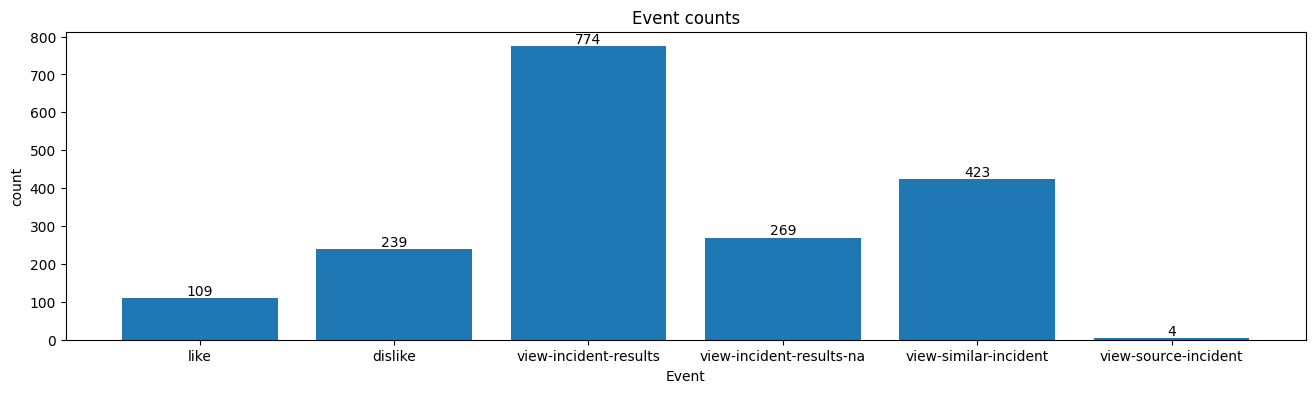

In [3]:
pprint(event_counts)

event_types = list(event_counts.keys())
counts = list(event_counts.values())
f, ax = plt.subplots(figsize=(16, 4))
plt.bar(range(len(event_types)), counts, tick_label=event_types)
plt.title('Event counts')
plt.xlabel('Event')
plt.ylabel('count')
# add the count above each bar
for i, count in enumerate(counts):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

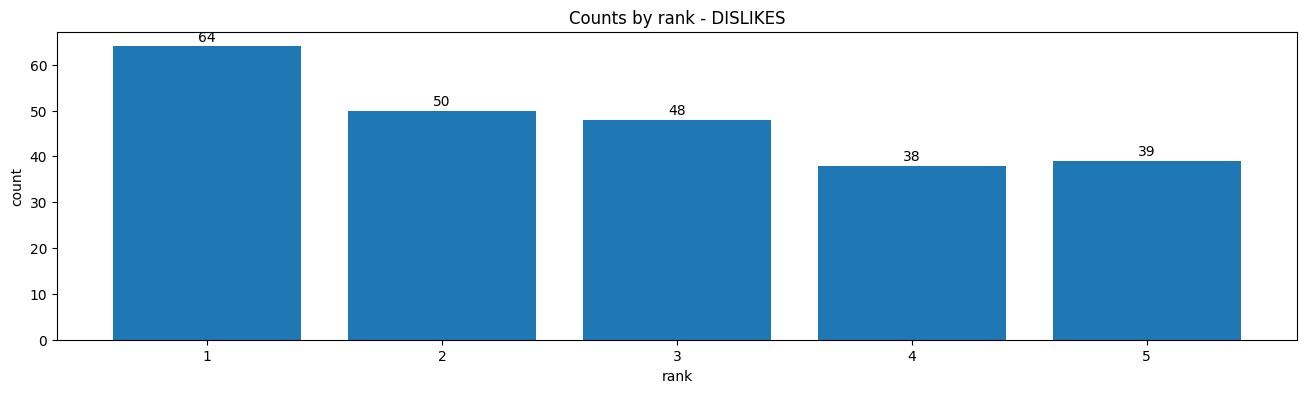

In [9]:
dislike_events = [event for event in events if event.event_type == EventType.DISLIKE.value]
dislike_event: Event
rank_count: dict[int, int] = {i: 0 for i in range(5)}
for dislike_event in dislike_events:
    rank_count[dislike_event.rank] += 1

f, ax = plt.subplots(figsize=(16, 4))
plt.bar(range(len(rank_count)), rank_count.values(), tick_label=list(range(1, 6)))
plt.title('Counts by rank - DISLIKES')
plt.xlabel('rank')
plt.ylabel('count')
# add the count above each bar
for i, count in enumerate(rank_count.values()):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

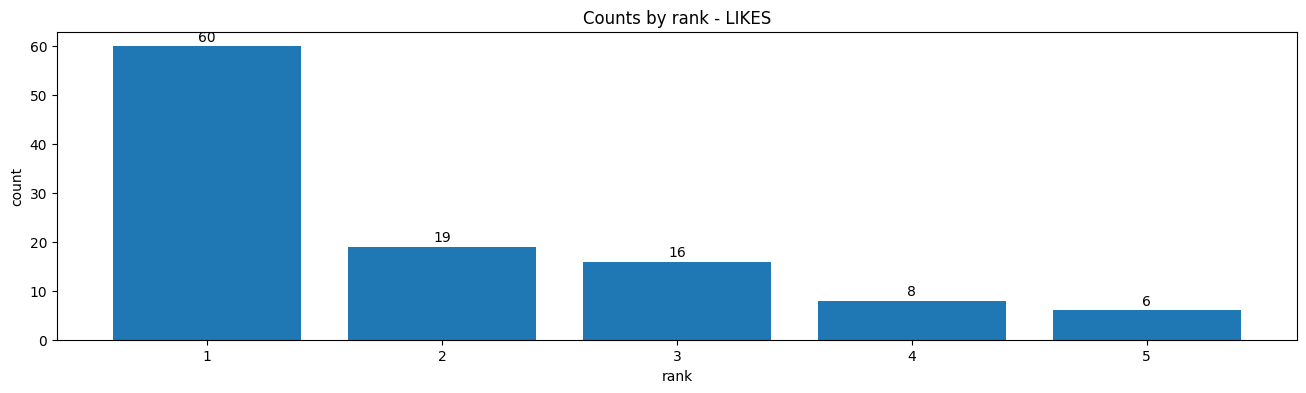

In [10]:
like_event: Event
rank_count: dict[int, int] = {i: 0 for i in range(5)}
like_events = [event for event in events if event.event_type == EventType.LIKE.value]
for like_event in like_events:
    rank_count[like_event.rank] += 1

f, ax = plt.subplots(figsize=(16, 4))
plt.bar(range(len(rank_count)), rank_count.values(), tick_label=list(range(1, 6)))
plt.title('Counts by rank - LIKES')
plt.xlabel('rank')
plt.ylabel('count')
# add the count above each bar
for i, count in enumerate(rank_count.values()):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')